In [39]:
# Загрузка библиотек
import pandas as pd
import numpy as np
from datetime import timedelta
import tensorflow
from tensorflow.keras import models
from sklearn.preprocessing import RobustScaler
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

In [40]:
# для примера обработки берется набор данных из data, поля TimeValue и Value.
# условия считывания - разделитель десятичных точка, разделитель столбцов запятая
day = pd.read_csv('4056_Nd_входящие данные дневные.csv', squeeze=True)
night = pd.read_csv('4056_Nd_входящие данные ночные.csv', squeeze=True)

In [41]:
# присваивание тайм-индекса набору данных
day.index = pd.to_datetime(day.TimeValue, dayfirst=True)
night.index = pd.to_datetime(night.TimeValue, dayfirst=True)

In [42]:
# данные интерполируются поминутно по индексу
res_day = day.Value.resample('s').interpolate().resample('1T').asfreq().dropna()
res_night = night.Value.resample('s').interpolate().resample('1T').asfreq().dropna()

In [43]:
# создание копии интерполированного набора для вставки окон
resedit_day = res_day
resedit_night = res_night

In [44]:
# последний день дневных и ночных данных для создания скользящих окон
last_24hours_day = resedit_day
last_24hours_night = resedit_night
last_24hours_day.name = 'target'
last_24hours_night.name = 'target'

In [45]:
# добавление 240 фреймов
for i in range(240):
    last_date = last_24hours_day[-1:].index + timedelta(minutes=1)
    last_24hours_day = last_24hours_day.append(pd.Series(index=last_date))
    last_date = last_24hours_night[-1:].index + timedelta(minutes=1)
    last_24hours_night = last_24hours_night.append(pd.Series(index=last_date))

In [46]:
# pd.Series в pd.DataFrame
last_24hours_day = last_24hours_day.to_frame(name='target')
last_24hours_night = last_24hours_night.to_frame(name='target')

In [47]:
# создание дамми-параметров по месяцу и часу
# день
last_24hours_day.insert(0,'Year',(last_24hours_day.index).year)
last_24hours_day.insert(1,'Month',(last_24hours_day.index).month)
last_24hours_day.insert(2,'Hour',(last_24hours_day.index).hour)
last_24hours_day.insert(3,'Minute',(last_24hours_day.index).minute)

# ночь
last_24hours_night.insert(0,'Year',(last_24hours_night.index).year)
last_24hours_night.insert(1,'Month',(last_24hours_night.index).month)
last_24hours_night.insert(2,'Hour',(last_24hours_night.index).hour)
last_24hours_night.insert(3,'Minute',(last_24hours_night.index).minute)

In [48]:
# подгонка под шаблон датафрейма для подачи в сеть 
c1 = ['Year', 'Month', 'Hour', 'Minute', 'target', 'Minus 300 minut',
       'Minus 300 minut prev_day', 'Minus 280 minut',
       'Minus 280 minut prev_day', 'Minus 260 minut',
       'Minus 260 minut prev_day', 'Minus 240 minut',
       'Minus 240 minut prev_day', 'Minus 220 minut',
       'Minus 220 minut prev_day', 'Minus 200 minut',
       'Minus 200 minut prev_day', 'Minus 180 minut',
       'Minus 180 minut prev_day', 'Minus 160 minut',
       'Minus 160 minut prev_day', 'Minus 140 minut',
       'Minus 140 minut prev_day', 'Minus 120 minut',
       'Minus 120 minut prev_day', 'Minus 100 minut',
       'Minus 100 minut prev_day', 'Minus 80 minut', 'Minus 80 minut prev_day',
       'Minus 60 minut', 'Minus 60 minut prev_day', 'Minus 40 minut',
       'Minus 40 minut prev_day', 'Minus 20 minut', 'Minus 20 minut prev_day',
       'prev_day', 'prev_prev_day']

df_ = pd.DataFrame(columns=c1)
frames = [df_, last_24hours_day]
last_24hours_day = pd.concat(frames, sort=False)

frames = [df_, last_24hours_night]
last_24hours_night = pd.concat(frames, sort=False)

In [49]:
# заменяем Nan в шаблонное сетке на 0
last_24hours_day = last_24hours_day.fillna(0)
last_24hours_night = last_24hours_night.fillna(0)

In [36]:
# загрузка параметров модели
model = models.load_model('best_model.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 36, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [50]:
# создание скользящих окон

# значение прошлого дня
last_24hours_day['prev_day'] = last_24hours_day.shift(periods=1440)['target'].values
last_24hours_night['prev_day'] = last_24hours_night.shift(periods=1440)['target'].values

# значение позапрошлого дня
last_24hours_day['prev_prev_day'] = last_24hours_day.shift(periods=2880)['target'].values
last_24hours_night['prev_prev_day'] = last_24hours_night.shift(periods=2880)['target'].values

# если нет значения позапрошлого дня заменить на значение прошлого дня
last_24hours_day['prev_prev_day'] = last_24hours_day['prev_prev_day'].fillna(last_24hours_day['prev_day'])
last_24hours_night['prev_prev_day'] = last_24hours_night['prev_prev_day'].fillna(last_24hours_night['prev_day'])


start_pos_day = last_24hours_day.shape[0] - 240
start_pos_night = last_24hours_night.shape[0] - 240
n=20

for i in range(0, 240, 20):
    for k in range(20, 320, n):
        # заполнение скользящих окон для 20-ки предсказываемых фреймов
        last_24hours_day[f'Minus {k} minut'] = last_24hours_day.shift(periods=k)['target'].values
        last_24hours_night[f'Minus {k} minut'] = last_24hours_night.shift(periods=k)['target'].values
        last_24hours_day[f'Minus {k} minut prev_day'] = last_24hours_day.shift(periods=k+1440)['target'].values
        last_24hours_night[f'Minus {k} minut prev_day'] = last_24hours_night.shift(periods=k+1440)['target'].values
    # предсказание таргета для 20-ки фреймов и заполнение столбца target предсказаными значениями
    day_pred = model.predict(last_24hours_day.iloc[start_pos_day+i:start_pos_day+i+20].drop('target', axis=1).to_numpy().reshape(20, last_24hours_day.shape[1]-1, 1).squeeze())
    night_pred = model.predict(last_24hours_night.iloc[start_pos_night+i:start_pos_night+i+20].drop('target', axis=1).to_numpy().reshape(20, last_24hours_day.shape[1]-1, 1).squeeze())
    last_24hours_day.iloc[start_pos_day+i:start_pos_day+i+20, last_24hours_day.columns.get_loc('target')] = day_pred
    last_24hours_night.iloc[start_pos_night+i:start_pos_night+i+20, last_24hours_night.columns.get_loc('target')] = night_pred

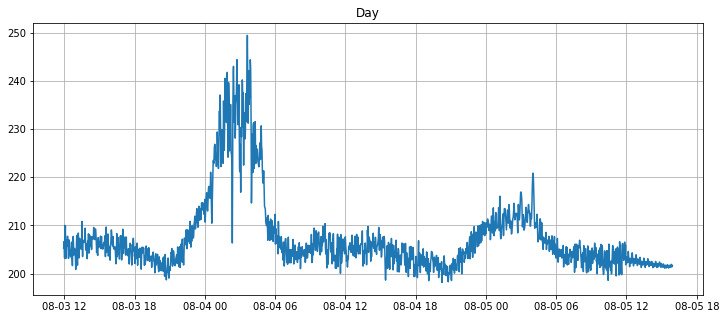

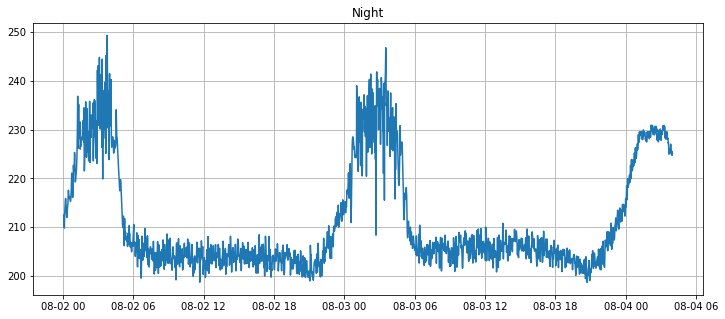

In [51]:
plt.figure(figsize=(12,5))
plt.title('Day')
plt.grid()
plt.plot(last_24hours_day.index, last_24hours_day['target'])

plt.figure(figsize=(12,5))
plt.title('Night')
plt.grid()
plt.plot(last_24hours_night.index, last_24hours_night['target'])

plt.show()

In [23]:
# сохранение датафреймов
# день
last_24hours_day.index.name = 'TimeValue'
last_24hours_day.iloc[-240:][['target']].to_csv('day_submission.csv')

# ночь
last_24hours_night.index.name = 'TimeValue'
last_24hours_night.iloc[-240:][['target']].to_csv('night_submission.csv')